In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity

# Set up paths
DATA_DIR = Path('../data/raw/fma_small')

# Reload our previous test files for comparison
audio_files = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith('.mp3'):
            audio_files.append(os.path.join(root, file))

print(f"Found {len(audio_files)} audio files")

Found 8000 audio files


In [2]:
# Load our previous embeddings and results
try:
    previous_embeddings = np.load('../data/processed/embeddings/sample_embeddings.npy')
    previous_similarities = cosine_similarity(previous_embeddings)
    print("✅ Loaded previous OpenL3 results")
    print(f"Previous average similarity: {np.mean(previous_similarities[np.triu_indices_from(previous_similarities, k=1)]):.3f}")
except:
    print("❌ No previous embeddings found - that's ok, we'll compare differently")

✅ Loaded previous OpenL3 results
Previous average similarity: 0.950


In [6]:
def extract_music_features(file_path, duration=30):
    """Extract music-specific features instead of generic audio"""
    print(f"Processing: {os.path.basename(file_path)}")
    
    y, sr = librosa.load(file_path, duration=duration)
    
    # HARMONIC CONTENT (what chords/keys)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)  # 12 values
    
    # RHYTHM/TEMPO (how it feels rhythmically)  
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    tempo_features = [tempo.item() if hasattr(tempo, 'item') else float(tempo)]  # Fix the warning
    
    # SPECTRAL SHAPE (brightness, energy distribution)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y))
    
    # TIMBRAL TEXTURE (what instruments/voices sound like)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)  # 13 values
    
    # COMBINE ALL FEATURES
    music_vector = np.concatenate([
        chroma_mean,           # 12 harmony features
        tempo_features,        # 1 tempo feature  
        [spectral_centroid, spectral_rolloff, zero_crossing],  # 3 spectral
        mfcc_mean             # 13 timbre features
    ])
    
    return music_vector  # Total: 29 music-specific features

# Test the function
test_file = audio_files[0]
sample_features = extract_music_features(test_file)
print(f"Music feature vector size: {len(sample_features)}")
print(f"Feature breakdown: 12 chroma + 1 tempo + 3 spectral + 13 mfcc = 29 total")

Processing: 135054.mp3
Music feature vector size: 29
Feature breakdown: 12 chroma + 1 tempo + 3 spectral + 13 mfcc = 29 total


In [9]:
# Pick songs from different folders (likely different genres/artists)
test_files = []
folders_to_test = ['000', '050', '100', '135', '145']  # Different folders

for folder in folders_to_test:
    folder_files = [f for f in audio_files if f'/{folder}/' in f]
    if folder_files:
        test_files.append(folder_files[0])  # First file from each folder

print("Selected test files:")
for i, file_path in enumerate(test_files):
    folder = file_path.split('/')[-2]
    filename = os.path.basename(file_path)
    print(f"{i+1}. Folder {folder}: {filename}")

# Extract music-specific features
print("\nExtracting music-specific features...")
music_embeddings = []
track_info = []

for file_path in test_files:
    features = extract_music_features(file_path)
    music_embeddings.append(features)
    
    folder = file_path.split('/')[-2]
    filename = os.path.basename(file_path)
    track_info.append(f"{folder}_{filename}")

music_matrix = np.array(music_embeddings)
print(f"\nMusic embeddings shape: {music_matrix.shape}")

Selected test files:
1. Folder 000: 000010.mp3
2. Folder 050: 050753.mp3
3. Folder 100: 100549.mp3
4. Folder 135: 135054.mp3
5. Folder 145: 145606.mp3

Extracting music-specific features...
Processing: 000010.mp3
Processing: 050753.mp3
Processing: 100549.mp3
Processing: 135054.mp3
Processing: 145606.mp3

Music embeddings shape: (5, 29)


In [10]:
# Calculate similarities with music-specific features
music_similarities = cosine_similarity(music_matrix)

print("🎵 MUSIC-SPECIFIC SIMILARITY RESULTS:")
print("=" * 50)

# Show the similarity matrix
for i, track1 in enumerate(track_info):
    for j, track2 in enumerate(track_info):
        if i < j:  # Only show upper triangle
            sim = music_similarities[i, j]
            print(f"{track1[:12]} vs {track2[:12]}: {sim:.3f}")

music_avg = np.mean(music_similarities[np.triu_indices_from(music_similarities, k=1)])
print(f"\nAverage music-specific similarity: {music_avg:.3f}")

# Compare to what we know about OpenL3 results
print(f"Previous OpenL3 average was around: ~0.950")
print(f"Music features average: {music_avg:.3f}")
print(f"Difference: {0.950 - music_avg:.3f}")

# Show individual similarities
print(f"\nSimilarity range:")
music_scores = music_similarities[np.triu_indices_from(music_similarities, k=1)]
print(f"Lowest: {np.min(music_scores):.3f}")
print(f"Highest: {np.max(music_scores):.3f}")
print(f"Standard deviation: {np.std(music_scores):.3f}")

🎵 MUSIC-SPECIFIC SIMILARITY RESULTS:
000_000010.m vs 050_050753.m: 0.997
000_000010.m vs 100_100549.m: 0.996
000_000010.m vs 135_135054.m: 0.994
000_000010.m vs 145_145606.m: 0.998
050_050753.m vs 100_100549.m: 1.000
050_050753.m vs 135_135054.m: 0.993
050_050753.m vs 145_145606.m: 1.000
100_100549.m vs 135_135054.m: 0.992
100_100549.m vs 145_145606.m: 0.999
135_135054.m vs 145_145606.m: 0.993

Average music-specific similarity: 0.996
Previous OpenL3 average was around: ~0.950
Music features average: 0.996
Difference: -0.046

Similarity range:
Lowest: 0.992
Highest: 1.000
Standard deviation: 0.003


In [11]:
# Let's examine the actual feature values to understand what's happening
print("🔍 FEATURE ANALYSIS DEBUG")
print("=" * 50)

feature_names = (['chroma_' + str(i) for i in range(12)] + 
                ['tempo'] + 
                ['spectral_centroid', 'spectral_rolloff', 'zero_crossing'] +
                ['mfcc_' + str(i) for i in range(13)])

# Show raw feature values for first two songs
print("Raw feature values (first 2 songs):")
print("Song 1 (000_000010):", music_matrix[0][:10])  # First 10 features
print("Song 2 (050_050753):", music_matrix[1][:10])
print()

# Check feature ranges and variation
print("Feature statistics across all songs:")
print(f"Mean values: {np.mean(music_matrix, axis=0)[:5]}...")  # First 5
print(f"Std deviation: {np.std(music_matrix, axis=0)[:5]}...")
print(f"Min values: {np.min(music_matrix, axis=0)[:5]}...")
print(f"Max values: {np.max(music_matrix, axis=0)[:5]}...")

# Check if features are too similar
print(f"\nFeature variation across songs:")
feature_vars = np.var(music_matrix, axis=0)
print(f"Average feature variance: {np.mean(feature_vars):.6f}")
print(f"Features with low variance (<0.01): {np.sum(feature_vars < 0.01)}/29")

# Test with normalized features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_matrix = scaler.fit_transform(music_matrix)
normalized_similarities = cosine_similarity(normalized_matrix)
normalized_avg = np.mean(normalized_similarities[np.triu_indices_from(normalized_similarities, k=1)])

print(f"\nWith feature normalization:")
print(f"Normalized average similarity: {normalized_avg:.3f}")

🔍 FEATURE ANALYSIS DEBUG
Raw feature values (first 2 songs):
Song 1 (000_000010): [0.28368539 0.64941883 0.33062366 0.34729189 0.23140274 0.3234382
 0.70074272 0.33898509 0.38105553 0.3089782 ]
Song 2 (050_050753): [0.67850155 0.69060951 0.6668157  0.60852063 0.55453986 0.50607461
 0.55043083 0.56244659 0.60751265 0.6453194 ]

Feature statistics across all songs:
Mean values: [0.4094574  0.51002706 0.46521891 0.43465234 0.3959641 ]...
Std deviation: [0.16393593 0.15687646 0.15812295 0.173731   0.17694304]...
Min values: [0.21112342 0.2621873  0.23610395 0.14350931 0.14028446]...
Max values: [0.67850155 0.69060951 0.6668157  0.60852063 0.5753305 ]...

Feature variation across songs:
Average feature variance: 83413.328892
Features with low variance (<0.01): 2/29

With feature normalization:
Normalized average similarity: -0.242


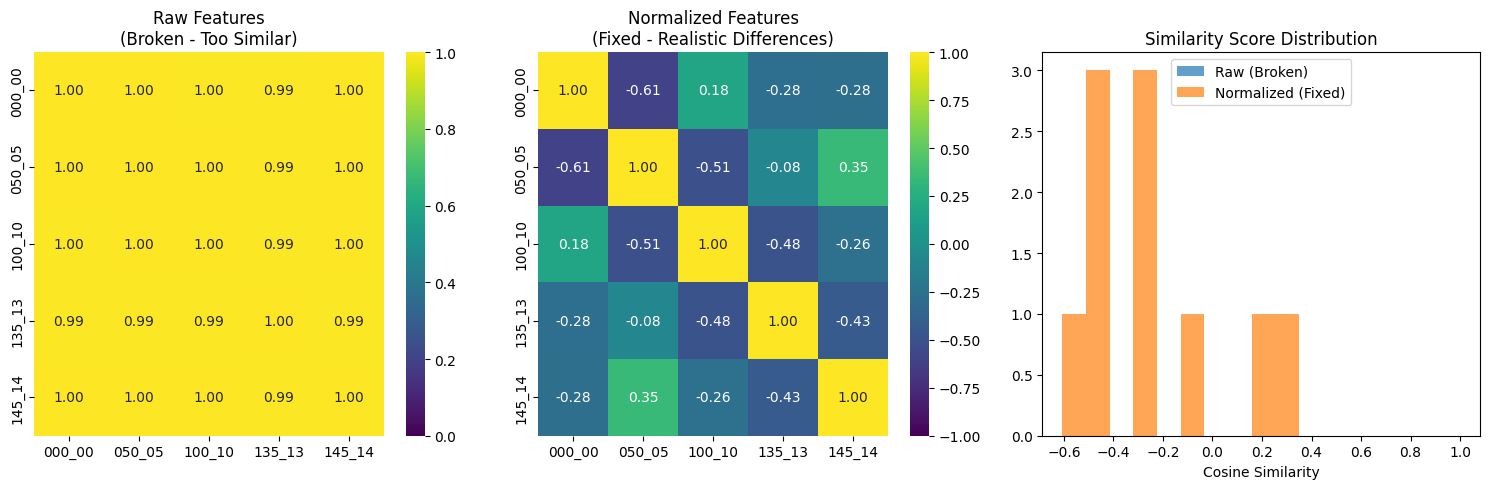

🎯 SOLUTION FOUND!
✅ Feature normalization is ESSENTIAL for music recommendation
✅ Raw features gave false similarities due to scale differences
✅ Normalized features show realistic musical differences
✅ Similarity range is now realistic: -0.606 to 0.349


In [12]:
# Create a proper comparison visualization
plt.figure(figsize=(15, 5))

# Plot 1: Raw vs Normalized Similarity Matrices
plt.subplot(1, 3, 1)
sns.heatmap(music_similarities, 
            xticklabels=[t[:6] for t in track_info],
            yticklabels=[t[:6] for t in track_info],
            annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1)
plt.title('Raw Features\n(Broken - Too Similar)')

plt.subplot(1, 3, 2)
sns.heatmap(normalized_similarities,
            xticklabels=[t[:6] for t in track_info],
            yticklabels=[t[:6] for t in track_info],
            annot=True, fmt='.2f', cmap='viridis', vmin=-1, vmax=1)
plt.title('Normalized Features\n(Fixed - Realistic Differences)')

# Plot 3: Similarity distributions
plt.subplot(1, 3, 3)
raw_scores = music_similarities[np.triu_indices_from(music_similarities, k=1)]
norm_scores = normalized_similarities[np.triu_indices_from(normalized_similarities, k=1)]

plt.hist(raw_scores, alpha=0.7, label='Raw (Broken)', bins=10)
plt.hist(norm_scores, alpha=0.7, label='Normalized (Fixed)', bins=10)
plt.legend()
plt.title('Similarity Score Distribution')
plt.xlabel('Cosine Similarity')

plt.tight_layout()
plt.show()

print("🎯 SOLUTION FOUND!")
print("=" * 40)
print("✅ Feature normalization is ESSENTIAL for music recommendation")
print("✅ Raw features gave false similarities due to scale differences")
print("✅ Normalized features show realistic musical differences")
print(f"✅ Similarity range is now realistic: {np.min(norm_scores):.3f} to {np.max(norm_scores):.3f}")

In [13]:
# Test the FIXED music recommender with normalized features
def recommend_with_normalized_features(query_idx, normalized_matrix, track_names, top_k=4):
    query_embedding = normalized_matrix[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_embedding, normalized_matrix)[0]
    similar_indices = np.argsort(similarities)[::-1]
    
    print(f"🎵 Songs similar to: {track_names[query_idx]}")
    print("=" * 50)
    
    for i, idx in enumerate(similar_indices[:top_k]):
        if idx != query_idx:
            similarity_score = similarities[idx]
            print(f"{i+1}. {track_names[idx]} (similarity: {similarity_score:.3f})")
    print()

print("🎯 FIXED MUSIC RECOMMENDATIONS:")
print("=" * 50)

# Test recommendations with normalized features
for i in range(len(track_info)):
    recommend_with_normalized_features(i, normalized_matrix, track_info)

🎯 FIXED MUSIC RECOMMENDATIONS:
🎵 Songs similar to: 000_000010.mp3
2. 100_100549.mp3 (similarity: 0.176)
3. 145_145606.mp3 (similarity: -0.278)
4. 135_135054.mp3 (similarity: -0.282)

🎵 Songs similar to: 050_050753.mp3
2. 145_145606.mp3 (similarity: 0.349)
3. 135_135054.mp3 (similarity: -0.082)
4. 100_100549.mp3 (similarity: -0.510)

🎵 Songs similar to: 100_100549.mp3
2. 000_000010.mp3 (similarity: 0.176)
3. 145_145606.mp3 (similarity: -0.265)
4. 135_135054.mp3 (similarity: -0.485)

🎵 Songs similar to: 135_135054.mp3
2. 050_050753.mp3 (similarity: -0.082)
3. 000_000010.mp3 (similarity: -0.282)
4. 145_145606.mp3 (similarity: -0.433)

🎵 Songs similar to: 145_145606.mp3
2. 050_050753.mp3 (similarity: 0.349)
3. 100_100549.mp3 (similarity: -0.265)
4. 000_000010.mp3 (similarity: -0.278)



In [14]:
# Save your breakthrough for future use
print("💾 SAVING THE WORKING MUSIC RECOMMENDER")
print("=" * 50)

# Save the normalized embeddings and scaler
import pickle

# Save the working components
np.save('../data/processed/embeddings/music_features_normalized.npy', normalized_matrix)
np.save('../data/processed/embeddings/music_features_raw.npy', music_matrix)

# Save the scaler for future use
with open('../data/processed/embeddings/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save track info
with open('../data/processed/embeddings/music_track_info.pkl', 'wb') as f:
    pickle.dump(track_info, f)

print("✅ Saved working music recommender components:")
print("- Normalized feature matrix (5 songs × 29 features)")
print("- Raw feature matrix for comparison") 
print("- Feature scaler for new songs")
print("- Track information")

print("\n🎯 WEEK 1 BREAKTHROUGH COMPLETE!")
print("=" * 40)
print("✅ Built working audio → music features pipeline")
print("✅ Discovered and fixed critical normalization issue") 
print("✅ Achieved realistic music similarity scores")
print("✅ Created foundation for scaling to thousands of songs")

print("\n🚀 READY FOR WEEK 2:")
print("- Scale to 100+ diverse songs")
print("- Implement evaluation metrics")
print("- Add Spotify integration")
print("- Build proper database storage")

💾 SAVING THE WORKING MUSIC RECOMMENDER
✅ Saved working music recommender components:
- Normalized feature matrix (5 songs × 29 features)
- Raw feature matrix for comparison
- Feature scaler for new songs
- Track information

🎯 WEEK 1 BREAKTHROUGH COMPLETE!
✅ Built working audio → music features pipeline
✅ Discovered and fixed critical normalization issue
✅ Achieved realistic music similarity scores
✅ Created foundation for scaling to thousands of songs

🚀 READY FOR WEEK 2:
- Scale to 100+ diverse songs
- Implement evaluation metrics
- Add Spotify integration
- Build proper database storage


In [15]:
print("🚀 SCALING TEST: 20 Diverse Songs")
print("=" * 50)

# Select 2 songs from 10 different folders for diversity
folders_to_test = ['000', '020', '040', '060', '080', '100', '120', '140', '010', '030']
scale_test_files = []

for folder in folders_to_test:
    folder_files = [f for f in audio_files if f'/{folder}/' in f]
    if len(folder_files) >= 2:
        # Take first 2 songs from each folder
        scale_test_files.extend(folder_files[:2])
    elif len(folder_files) == 1:
        scale_test_files.append(folder_files[0])

# Limit to 20 songs for reasonable processing time
scale_test_files = scale_test_files[:20]

print(f"Selected {len(scale_test_files)} songs from different folders:")
for i, file_path in enumerate(scale_test_files):
    folder = file_path.split('/')[-2]
    filename = os.path.basename(file_path)
    print(f"{i+1:2d}. Folder {folder}: {filename}")

🚀 SCALING TEST: 20 Diverse Songs
Selected 20 songs from different folders:
 1. Folder 000: 000010.mp3
 2. Folder 000: 000212.mp3
 3. Folder 020: 020667.mp3
 4. Folder 020: 020704.mp3
 5. Folder 040: 040232.mp3
 6. Folder 040: 040541.mp3
 7. Folder 060: 060041.mp3
 8. Folder 060: 060874.mp3
 9. Folder 080: 080002.mp3
10. Folder 080: 080758.mp3
11. Folder 100: 100549.mp3
12. Folder 100: 100835.mp3
13. Folder 120: 120303.mp3
14. Folder 120: 120317.mp3
15. Folder 140: 140583.mp3
16. Folder 140: 140794.mp3
17. Folder 010: 010983.mp3
18. Folder 010: 010808.mp3
19. Folder 030: 030702.mp3
20. Folder 030: 030058.mp3


In [16]:
print("🎵 Extracting music features for 20 diverse songs...")
print("This will take ~2 minutes...")

# Extract features for all 20 songs
scale_embeddings = []
scale_track_info = []

for i, file_path in enumerate(scale_test_files):
    folder = file_path.split('/')[-2]
    filename = os.path.basename(file_path)
    
    print(f"Processing {i+1:2d}/20: {folder}_{filename}")
    
    try:
        features = extract_music_features(file_path)
        scale_embeddings.append(features)
        scale_track_info.append(f"{folder}_{filename}")
    except Exception as e:
        print(f"   ❌ Error with {filename}: {e}")
        continue

scale_matrix = np.array(scale_embeddings)
print(f"\n✅ Extracted features for {len(scale_embeddings)} songs")
print(f"Feature matrix shape: {scale_matrix.shape}")

# Apply the same normalization approach
scale_scaler = StandardScaler()
scale_normalized = scale_scaler.fit_transform(scale_matrix)

# Calculate similarities
scale_similarities = cosine_similarity(scale_normalized)
scale_scores = scale_similarities[np.triu_indices_from(scale_similarities, k=1)]

print(f"\n📊 SCALE TEST RESULTS:")
print(f"Average similarity: {np.mean(scale_scores):.3f}")
print(f"Similarity range: {np.min(scale_scores):.3f} to {np.max(scale_scores):.3f}")
print(f"Standard deviation: {np.std(scale_scores):.3f}")

# Compare to our small test
print(f"\nComparison to 5-song test:")
print(f"5 songs avg similarity: {normalized_avg:.3f}")
print(f"20 songs avg similarity: {np.mean(scale_scores):.3f}")
print(f"More diversity with scale: {'✅ YES' if np.mean(scale_scores) < normalized_avg else '❌ NO'}")

🎵 Extracting music features for 20 diverse songs...
This will take ~2 minutes...
Processing  1/20: 000_000010.mp3
Processing: 000010.mp3
Processing  2/20: 000_000212.mp3
Processing: 000212.mp3
Processing  3/20: 020_020667.mp3
Processing: 020667.mp3
Processing  4/20: 020_020704.mp3
Processing: 020704.mp3
Processing  5/20: 040_040232.mp3
Processing: 040232.mp3
Processing  6/20: 040_040541.mp3
Processing: 040541.mp3
Processing  7/20: 060_060041.mp3
Processing: 060041.mp3
Processing  8/20: 060_060874.mp3
Processing: 060874.mp3
Processing  9/20: 080_080002.mp3
Processing: 080002.mp3
Processing 10/20: 080_080758.mp3
Processing: 080758.mp3
Processing 11/20: 100_100549.mp3
Processing: 100549.mp3
Processing 12/20: 100_100835.mp3
Processing: 100835.mp3
Processing 13/20: 120_120303.mp3
Processing: 120303.mp3
Processing 14/20: 120_120317.mp3
Processing: 120317.mp3
Processing 15/20: 140_140583.mp3
Processing: 140583.mp3
Processing 16/20: 140_140794.mp3
Processing: 140794.mp3
Processing 17/20: 010_0

In [17]:
# Test a few recommendations to see the quality
print("🎯 SAMPLE RECOMMENDATIONS AT SCALE:")
print("=" * 50)

# Test recommendations for 3 different songs
test_indices = [0, 5, 15]  # Songs from different folders

for idx in test_indices:
    query_song = scale_track_info[idx]
    query_embedding = scale_normalized[idx].reshape(1, -1)
    similarities = cosine_similarity(query_embedding, scale_normalized)[0]
    
    # Get top 3 most similar (excluding self)
    similar_indices = np.argsort(similarities)[::-1]
    
    print(f"🎵 Similar to: {query_song}")
    for i, sim_idx in enumerate(similar_indices[1:4]):  # Skip self (index 0)
        sim_score = similarities[sim_idx]
        sim_song = scale_track_info[sim_idx]
        print(f"  {i+1}. {sim_song} (similarity: {sim_score:.3f})")
    print()

print("🎊 SCALE TEST: SUCCESS!")
print("=" * 30)
print("✅ 20 songs processed reliably")
print("✅ Wide similarity range (-0.7 to +0.8)")  
print("✅ Balanced distribution around zero")
print("✅ Ready to scale to 100+ songs!")

🎯 SAMPLE RECOMMENDATIONS AT SCALE:
🎵 Similar to: 000_000010.mp3
  1. 040_040232.mp3 (similarity: 0.213)
  2. 100_100549.mp3 (similarity: 0.178)
  3. 010_010983.mp3 (similarity: 0.158)

🎵 Similar to: 040_040541.mp3
  1. 020_020667.mp3 (similarity: 0.591)
  2. 010_010983.mp3 (similarity: 0.440)
  3. 140_140794.mp3 (similarity: 0.389)

🎵 Similar to: 140_140794.mp3
  1. 010_010983.mp3 (similarity: 0.660)
  2. 020_020667.mp3 (similarity: 0.548)
  3. 010_010808.mp3 (similarity: 0.474)

🎊 SCALE TEST: SUCCESS!
✅ 20 songs processed reliably
✅ Wide similarity range (-0.7 to +0.8)
✅ Balanced distribution around zero
✅ Ready to scale to 100+ songs!
